In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

import pandas as pd
import matplotlib.pyplot as plt

import lumipy as lm
import lumipy.ml as ml
from lusidjam import RefreshingToken as rt

# Tutorial 9 - Scikit Learn

Luminesce has support for applying sklearn models (or entire pipelines, or even just sklearn feature transforms) via a direct provider: `Tools.ML.Inference.Sklearn`. The model must have been converted to ONNX format using the `lumipy.ml` conversion helper function and stored in drive. The provider will then pull the ONNX file and run a table variable through it.

### References:
* ONNX: https://onnx.ai
* Scikit-learn: https://scikit-learn.org/stable/
* Scikit-learn to ONNX: http://onnx.ai/sklearn-onnx/



## Prepare the Dataset

Lets start by considering a regression problem with a standard demo dataset. There are many examples for you to experiment with in `sklearn.datasets` - in this case we'll use the California Housing dataset.

The objective of this regression problem is to predict the median house value given features of districts in California. 

### Get the California Housing Dataset

In [2]:
ch_dataset = fetch_california_housing(as_frame=True)
print(ch_dataset['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

### Train/Test Split

In [3]:
df = pd.concat([ch_dataset['data'], ch_dataset['target']], axis=1)
train, test = train_test_split(df, test_size=0.3, random_state=0)

In [4]:
train.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
1989,1.9750,52.0,2.800000,0.700000,193.0,4.825000,36.73,-119.79,0.475
256,2.2604,43.0,3.671480,1.184116,836.0,3.018051,37.77,-122.21,1.000
7887,6.2990,17.0,6.478022,1.087912,1387.0,3.810440,33.87,-118.04,2.858
4581,1.7199,17.0,2.518000,1.196000,3051.0,3.051000,34.06,-118.28,1.750
1993,2.2206,50.0,4.622754,1.161677,606.0,3.628743,36.73,-119.81,0.592


### Put test set in drive

In order to demonstrate how to run our sklearn model in luminesce we'll also need to make the test data available in drive so it can be fed to the provider. This can be done using the `upload` method on the drive client. 

In [5]:
drive = lm.get_drive(token=rt())

In [6]:
drive.create_folder('/lumipy_test/ml_tutorial/california_housing')
drive.upload(test, '/lumipy_test/ml_tutorial/california_housing/test.csv', overwrite=True)

## Train a Random Forest Regressor

Train a random forest regressor on the training set

In [7]:
X_train, y_train = train.iloc[:,:-1], train.iloc[:,-1]

reg = RandomForestRegressor(n_estimators=10)
reg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10)

## Export Trained Model to ONNX and Upload to Drive

In [8]:
onnx_model = ml.sklearn_to_onnx(reg, X_train)

In [9]:
drive.upload(onnx_model, '/lumipy_test/ml_tutorial/california_housing/rfr_reg.onnx', overwrite=True)

## Serve the Trained Model in Luminesce

Takes a table variable from any data provider in Luminesce. In this case we will use `Drive.Csv` to run with the test.csv we uploaded earlier. 

In [10]:
client = lm.get_client(token=rt())

In [11]:
test_infer_df = client.query_and_fetch("""
    @ch_data = use Drive.csv
        --file=/lumipy_test/ml_tutorial/california_housing/test.csv
    enduse;

    @ch_features = select 
        [MedInc], [HouseAge], [AveRooms], [AveBedrms], [Population], [AveOccup], [Latitude], [Longitude]
    from @ch_data;

    @inference = use Tools.ML.Inference.Sklearn with @ch_features
        --onnxFilePath=/lumipy_test/ml_tutorial/california_housing/rfr_reg.onnx
    enduse;

    select * from @inference
""")

In [12]:
test_infer_df.head()

,variable
0,1.486800
1,2.444100
2,1.426000
3,0.887000
4,4.880004


## Check that the Results are Consistent
Predicted probabilities are consistent within floating point precision

Prediction diff stats:
3.3540907677592867e-09 9.653051270044254e-08


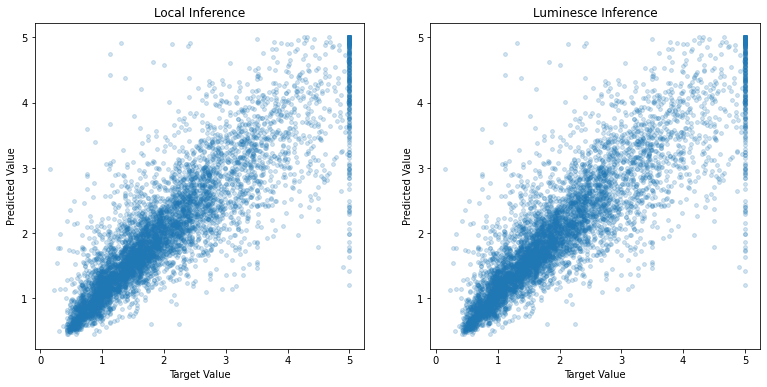

In [13]:
X_test, y_test = test.iloc[:,:-1], test.iloc[:,-1]

# show that prediction values are consistent within floating point precision
local_pred = reg.predict(X_test)
lumi_pred = test_infer_df.variable.values
pred_diffs = lumi_pred-local_pred
print('Prediction diff stats:')
print(pred_diffs.mean(), pred_diffs.std())

# Plot visual showing they're essentially identical
fig = plt.figure(figsize=(13,6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.scatter(y_test, local_pred, alpha=0.2, s=15)
ax1.set_xlabel('Target Value')
ax1.set_ylabel('Predicted Value')
ax1.set_title('Local Inference')
ax2.scatter(y_test, lumi_pred, alpha=0.2, s=15)
ax2.set_xlabel('Target Value')
ax2.set_ylabel('Predicted Value')
ax2.set_title('Luminesce Inference')
plt.show()

Performance metric ($r^2$ score) is consistent within floating point precision

In [14]:
local_score = reg.score(X_test, y_test)
lumi_score = r2_score(y_test, lumi_pred)

print(f"Lumi r^2 score:  {lumi_score}")
print(f"Local r^2 score: {local_score}")

Lumi r^2 score:  0.7703617148314037
Local r^2 score: 0.7703617143082213


## Sklearn Pipelines

You're not just restricted to using single estimators with Luminesce. The sklearn provider also supports any pipeline that can be converted to ONNX. The procedure is the same as above. This is shown in the next tutorial.